In [1]:

%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
pd.options.display.mpl_style = 'default'

import inspect, os
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(0,parentdir) 
from src.dashboard_helpers import Test, custom_amount_stats
from src.data_retrieval import *
from db_utils import query_hive_ssh
import copy


def doctor_payment_data(t, n_clicks, conversion_rate, average_donation, banner_name, method_name ):
    t = copy.deepcopy(t)
    donations = int(n_clicks * conversion_rate)
    clicks = t.data[banner_name]['clicks']
    clicks = clicks.reset_index()
    del clicks['timestamp']
    gw = pd.DataFrame([[0, method_name]]*n_clicks )
    gw.columns = ['impressions_seen', 'payment_method']
    t.data[banner_name]['clicks'] = pd.concat([clicks, gw], axis=0)

    dons = t.data[banner_name]['donations']
    dons = dons.reset_index()
    del dons['timestamp']
    gw = pd.DataFrame([[average_donation, 0, method_name]]*donations )
    gw.columns = ['amount', 'impressions_seen', 'payment_method']
    t.data[banner_name]['donations'] = pd.concat([dons, gw], axis=0)
    return t

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


In [2]:
hive_query = """
SELECT 
  a.banner,
  a.recurring,
  COUNT(*) as n 
FROM (
    SELECT
      PARSE_URL(CONCAT('http://bla.org/woo/', uri_query), 'QUERY', 'bannername') as banner,
      PARSE_URL(CONCAT('http://bla.org/woo/', uri_query), 'QUERY', 'recurring') as recurring
    FROM wmf.webrequest 
    WHERE year = 2015
      AND (month = 4 AND day = 10 AND hour in (12, 13, 14))
      OR  (month=4   AND day = 28 AND hour in (12, 13, 14))
      AND ((webrequest_source = 'text') OR (webrequest_source = 'mobile'))
      AND uri_host = 'meta.wikimedia.org'
      AND uri_path = '/wiki/Special:RecordImpression'
      AND PARSE_URL(CONCAT('http://bla.org/woo/', uri_query), 'QUERY', 'paymentclick') = 'true'
      AND PARSE_URL(CONCAT('http://bla.org/woo/', uri_query), 'QUERY', 'paymentmethod') = 'google'
      AND length(PARSE_URL(CONCAT('http://bla.org/woo/', uri_query), 'QUERY', 'amount')) < 4
) a
GROUP BY
  a.banner,
  a.recurring
"""

d = query_hive_ssh(hive_query, 'googlequery')


In [5]:
d[1:]

,a.banner,a.recurring,n
1,B15_0410_enUS_dsk_pm_gib,False,528
2,B15_0410_enUS_ipd_pm_gib,False,41
3,B15_0410_enUS_mob_pm_gib,False,196


#Desktop

In [33]:
start = '2015-04-10 12:00'
end =  '2015-05-10 23:59'   
a = 'B15_0410_enUS_dsk_pm_ctl'
b = 'B15_0410_enUS_dsk_pm_gib'
c = 'B15_0410_enUS_dsk_pm_gib2'

In [3]:
t_dsk = Test(a, b,c, start=start, stop = end)

In [34]:
# Doctor the Click and Donation Counts
clicks = 528
conversion_rate = 0.7
average_donation = 9.3
t_dsk_gw = doctor_payment_data(t_dsk, clicks, conversion_rate, average_donation, b, 'gw' )
t_dsk_gw.get_payment_method_details()

donations  clicks  conversion_rate  \
B15_0410_enUS_dsk_pm_ctl  amazon        1178    1742        67.623421   
                          cc            1642    3175        51.716535   
                          paypal        3006    4040        74.405941   
                          rcc             42     162        25.925926   
                          rpaypal         46     128        35.937500   
B15_0410_enUS_dsk_pm_gib  amazon        1020    1403        72.701354   
                          cc            1588    2958        53.684922   
                          gw             369     528        69.886364   
                          paypal        3233    4144        78.016409   
                          rcc             48     181        26.519337   
                          rpaypal         42     144        29.166667   
B15_0410_enUS_dsk_pm_gib2 amazon          42     120        35.000000   
                          cc              24     130        18.461538   
                          paypal          28     137        20.437956   
                          rcc            NaN       2              NaN   
                          rpaypal        NaN       4              NaN   

                                   percent clicked on  percent donated on  \
B15_0410_enUS_dsk_pm_ctl  amazon            18.838542           19.918837   
                          cc                34.335460           27.764626   
                          paypal            43.689845           50.828542   
                          rcc                1.751920            0.710179   
                          rpaypal            1.384233            0.777815   
B15_0410_enUS_dsk_pm_gib  amazon            14.992520           16.190476   
                          cc                31.609318           25.206349   
                          gw                 5.642231            5.857143   
                          paypal            44.282966           51.317460   
                          rcc                1.934174            0.761905   
                          rpaypal            1.538790            0.666667   
B15_0410_enUS_dsk_pm_gib2 amazon            30.534351           44.680851   
                          cc                33.078880           25.531915   
                          paypal            34.860051           29.787234   
                          rcc                0.508906                 NaN   
                          rpaypal            1.017812                 NaN   

                                   total_amount  ave_amount_ro  
B15_0410_enUS_dsk_pm_ctl  amazon       12110.00       9.615713  
                          cc           27458.09      13.985627  
                          paypal       31327.72       9.332790  
                          rcc            447.00       8.463415  
                          rpaypal        181.00       3.934783  
B15_0410_enUS_dsk_pm_gib  amazon       12501.00      10.229394  
                          cc           27579.00      13.896214  
                          gw            3431.70            NaN  
                          paypal       33238.80       9.638255  
                          rcc            264.50       5.510417  
                          rpaypal        189.00       4.500000  
B15_0410_enUS_dsk_pm_gib2 amazon         303.00       7.214286  
                          cc             267.00      11.125000  
                          paypal         286.00       8.740741  
                          rcc               NaN            NaN  
                          rpaypal           NaN            NaN

###Clicks per Impression

,P(Winner),Winners Lift,CI
B15_0410_enUS_dsk_pm_gib,0.81368,"(0.00%, 0.00%)","(0.002819, 0.002936)"
B15_0410_enUS_dsk_pm_ctl,0.18632,"(-1.53%, 4.27%)","(0.002782, 0.002898)"


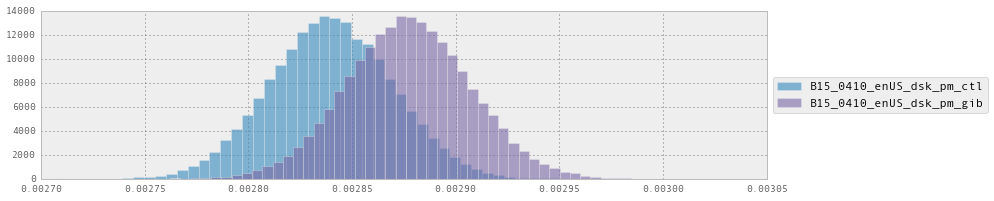

In [35]:
t_dsk_gw.rate_stats(a, b, rate = 'clicks/impressions', conf = 95)

###Donations per Impression

,P(Winner),Winners Lift,CI
B15_0410_enUS_dsk_pm_gib,0.99984,"(0.00%, 0.00%)","(0.001889, 0.001985)"
B15_0410_enUS_dsk_pm_ctl,0.00016,"(2.89%, 10.47%)","(0.001771, 0.001864)"


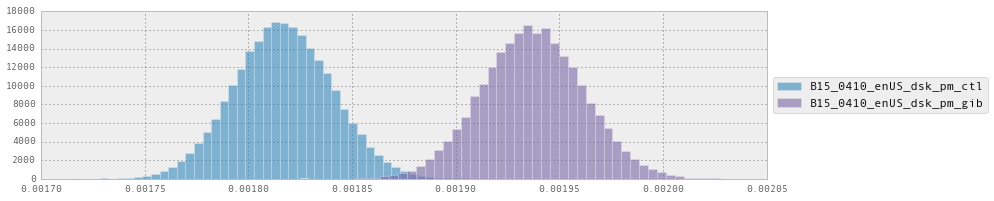

In [36]:
t_dsk_gw.rate_stats(a, b, rate = 'donations/impressions', conf = 95)

### Amount per impression

Counter({3.0: 1935, 5.0: 1395, 10.0: 1079, 20.0: 701, 30.0: 368, 50.0: 228, 100.0: 87, 15.0: 47, 25.0: 23, 1.0: 18, 2.0: 8, 6.0: 7, 200.0: 2, 75.0: 2, 12.0: 2, 18.0: 2, 36.0: 2, 4.0: 1, 7.0: 1, 14.0: 1, 33.0: 1, 40.0: 1, 42.0: 1, 365.0: 1, 250.0: 1})


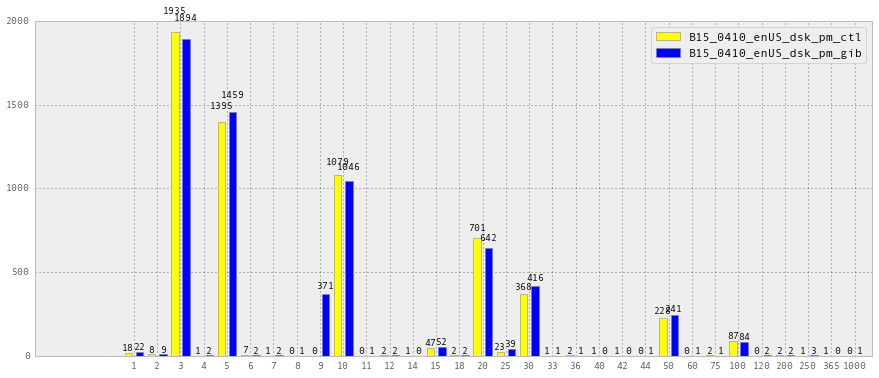

In [37]:
t_dsk_gw.compare_donation_amounts(a, b )

Values for banner  B15_0410_enUS_dsk_pm_ctl : [3.0, 5.0, 10.0, 20.0, 30.0, 50.0, 100.0, 15.0, 25.0]
Values for banner  B15_0410_enUS_dsk_pm_gib : [3.0, 5.0, 10.0, 20.0, 30.0, 9.3000000000000007, 50.0, 100.0, 15.0, 25.0]


,P(Winner),Winners Lift,CI
B15_0410_enUS_dsk_pm_gib,0.98178,"(0.00%, 0.00%)","(0.022045, 0.023890)"
B15_0410_enUS_dsk_pm_ctl,0.01822,"(0.37%, 12.70%)","(0.020693, 0.022492)"


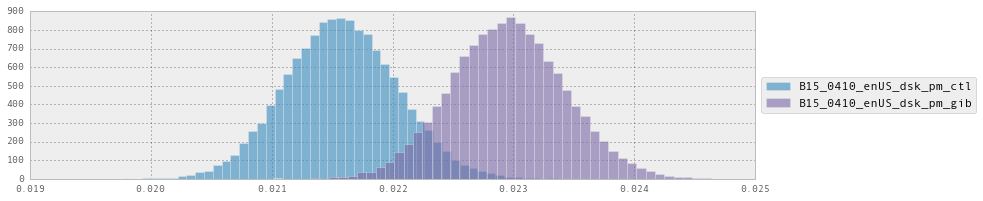

In [38]:
values = {
a: 9,
b: 10
}

t_dsk_gw.amount_stats( values, conf = 95, rate = 'donations/impressions')

#Mobile

In [39]:
a = 'B15_0410_enUS_mob_pm_ctl'
b = 'B15_0410_enUS_mob_pm_gib'
c = 'B15_0410_enUS_mob_pm_gib2'

In [14]:
t_mob = Test(a, b,c, start=start, stop = end)
#t_mob.get_payment_method_details()

In [40]:
# Doctor the Click and Donation Counts
clicks = 196
conversion_rate = 0.55
average_donation = 8.4
t_mob_gw = doctor_payment_data(t_mob, clicks, conversion_rate, average_donation, b, 'gw' )
t_mob_gw.get_payment_method_details()

donations  clicks  conversion_rate  \
B15_0410_enUS_mob_pm_ctl  amazon        367     585        62.735043   
                          cc            229     714        32.072829   
                          paypal        659    1277        51.605325   
B15_0410_enUS_mob_pm_gib  amazon        326     516        63.178295   
                          cc            275     785        35.031847   
                          gw            107     196        54.591837   
                          paypal        660    1285        51.361868   
B15_0410_enUS_mob_pm_gib2 amazon         19      34        55.882353   
                          cc              7      21        33.333333   
                          paypal          3      25        12.000000   

                                  percent clicked on  percent donated on  \
B15_0410_enUS_mob_pm_ctl  amazon           22.709627           29.243028   
                          cc               27.717391           18.247012   
                          paypal           49.572981           52.509960   
B15_0410_enUS_mob_pm_gib  amazon           18.547807           23.830409   
                          cc               28.217110           20.102339   
                          gw                7.045291            7.821637   
                          paypal           46.189792           48.245614   
B15_0410_enUS_mob_pm_gib2 amazon           42.500000           65.517241   
                          cc               26.250000           24.137931   
                          paypal           31.250000           10.344828   

                                  total_amount  ave_amount_ro  
B15_0410_enUS_mob_pm_ctl  amazon       3095.00       8.433243  
                          cc           2700.50      10.224444  
                          paypal       5860.00       7.637195  
B15_0410_enUS_mob_pm_gib  amazon       2678.00       8.214724  
                          cc           3499.00      10.776952  
                          gw            898.80            NaN  
                          paypal       5440.94       7.684360  
B15_0410_enUS_mob_pm_gib2 amazon        105.00       5.526316  
                          cc             33.00       4.714286  
                          paypal         21.00       7.000000

###Clicks per impression

,P(Winner),Winners Lift,CI
B15_0410_enUS_mob_pm_gib,0.98142,"(0.00%, 0.00%)","(0.003514, 0.003783)"
B15_0410_enUS_mob_pm_ctl,0.01858,"(0.32%, 11.63%)","(0.003314, 0.003579)"


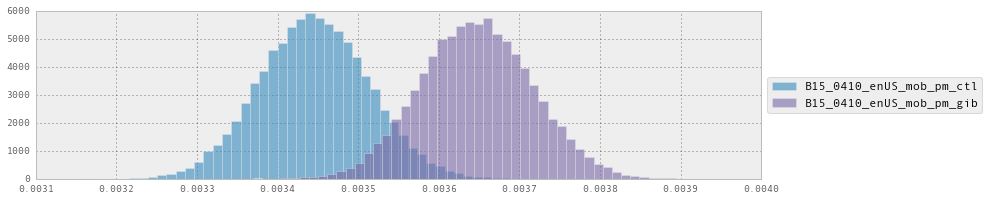

In [41]:
t_mob_gw.rate_stats(a, b, rate = 'clicks/impressions', conf = 95)

### Donations per impression

,P(Winner),Winners Lift,CI
B15_0410_enUS_mob_pm_gib,0.95484,"(0.00%, 0.00%)","(0.001701, 0.001890)"
B15_0410_enUS_mob_pm_ctl,0.04516,"(-1.07%, 15.35%)","(0.001588, 0.001774)"


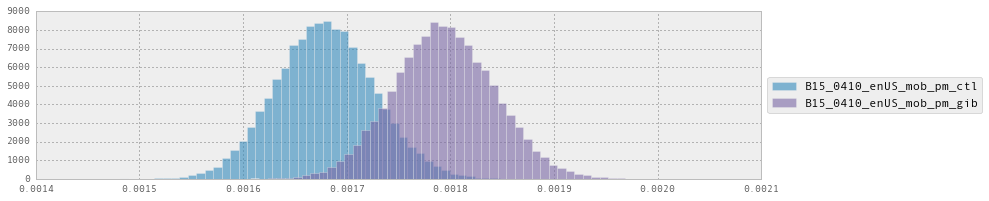

In [42]:
t_mob_gw.rate_stats(a, b, rate = 'donations/impressions', conf = 95)

### Amount per impression

Counter({3.0: 772, 15.0: 280, 20.0: 120, 50.0: 23, 5.0: 17, 10.0: 16, 1.0: 12, 100.0: 5, 7.0: 3, 11.0: 2, 6.0: 1, 8.0: 1, 500.0: 1, 25.0: 1, 250.0: 1})


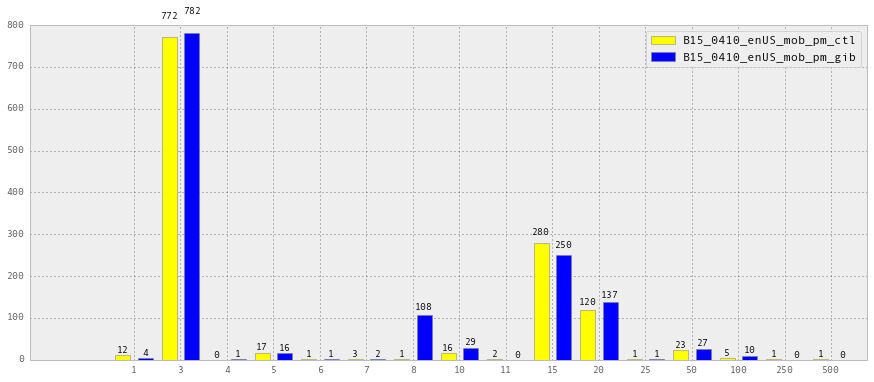

In [19]:
t_mob_gw.compare_donation_amounts(a, b )

Values for banner  B15_0410_enUS_mob_pm_ctl : [3.0, 15.0, 20.0, 50.0, 5.0, 10.0]
Values for banner  B15_0410_enUS_mob_pm_gib : [3.0, 15.0, 20.0, 8.4000000000000004, 10.0, 50.0, 5.0]


,P(Winner),Winners Lift,CI
B15_0410_enUS_mob_pm_gib,0.93496,"(0.00%, 0.00%)","(0.014047, 0.016338)"
B15_0410_enUS_mob_pm_ctl,0.06504,"(-2.48%, 21.65%)","(0.012845, 0.015081)"


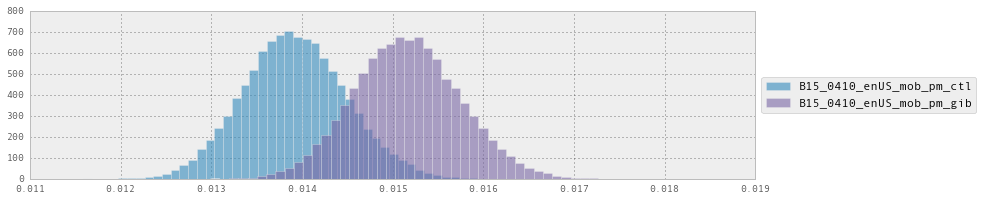

In [21]:
values = {
a: 6,
b: 7
}

t_mob_gw.amount_stats( values, conf = 95, rate = 'donations/impressions')

#Ipad

In [44]:
a = 'B15_0410_enUS_ipd_pm_ctl'
b = 'B15_0410_enUS_ipd_pm_gib'
c = 'B15_0410_enUS_ipd_pm_gib2'


In [22]:

t_ipd = Test(a, b,c, start=start, stop = end)
#t_ipd.get_payment_method_details()

In [23]:
# Doctor the Click and Donation Counts
clicks = 41
conversion_rate = 0.55
average_donation = 9.6
t_ipd_gw = doctor_payment_data(t_ipd, clicks, conversion_rate, average_donation, b, 'gw' )
t_ipd_gw.get_payment_method_details()

donations  clicks  conversion_rate  \
B15_0410_enUS_ipd_pm_ctl  amazon        139     218        63.761468   
                          cc             78     235        33.191489   
                          paypal        238     475        50.105263   
B15_0410_enUS_ipd_pm_gib  amazon        111     179        62.011173   
                          cc            100     254        39.370079   
                          gw             22      41        53.658537   
                          paypal        241     443        54.401806   
B15_0410_enUS_ipd_pm_gib2 amazon          1       7        14.285714   
                          cc              1       8        12.500000   
                          paypal          1       3        33.333333   

                                  percent clicked on  percent donated on  \
B15_0410_enUS_ipd_pm_ctl  amazon           23.491379           30.549451   
                          cc               25.323276           17.142857   
                          paypal           51.185345           52.307692   
B15_0410_enUS_ipd_pm_gib  amazon           19.520174           23.417722   
                          cc               27.699019           21.097046   
                          gw                4.471101            4.641350   
                          paypal           48.309706           50.843882   
B15_0410_enUS_ipd_pm_gib2 amazon           38.888889           33.333333   
                          cc               44.444444           33.333333   
                          paypal           16.666667           33.333333   

                                  total_amount  ave_amount_ro  
B15_0410_enUS_ipd_pm_ctl  amazon        1736.0       9.896296  
                          cc            1249.0      14.922078  
                          paypal        2676.0      10.110638  
B15_0410_enUS_ipd_pm_gib  amazon        1420.0      12.000000  
                          cc            1539.0      14.535354  
                          gw             211.2            NaN  
                          paypal        3000.0      11.344538  
B15_0410_enUS_ipd_pm_gib2 amazon           3.0       3.000000  
                          cc               5.0       5.000000  
                          paypal           3.0       3.000000

### Clicks per Impression

,P(Winner),Winners Lift,CI
B15_0410_enUS_ipd_pm_ctl,0.5711,"(0.00%, 0.00%)","(0.007488, 0.008506)"
B15_0410_enUS_ipd_pm_gib,0.4289,"(-7.90%, 10.45%)","(0.007419, 0.008443)"


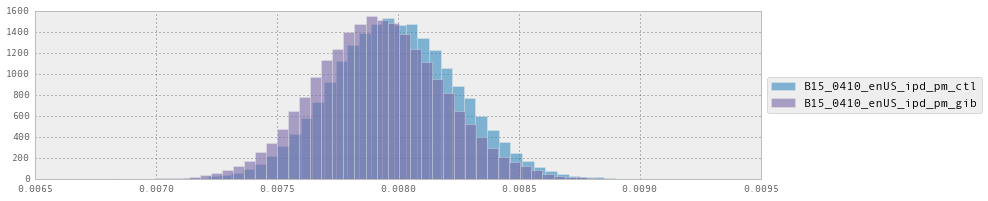

In [26]:
t_ipd_gw.rate_stats(a, b, rate = 'clicks/impressions', conf = 95)

### Donations per Impression

,P(Winner),Winners Lift,CI
B15_0410_enUS_ipd_pm_gib,0.75016,"(0.00%, 0.00%)","(0.003736, 0.004473)"
B15_0410_enUS_ipd_pm_ctl,0.24984,"(-8.07%, 18.90%)","(0.003569, 0.004290)"


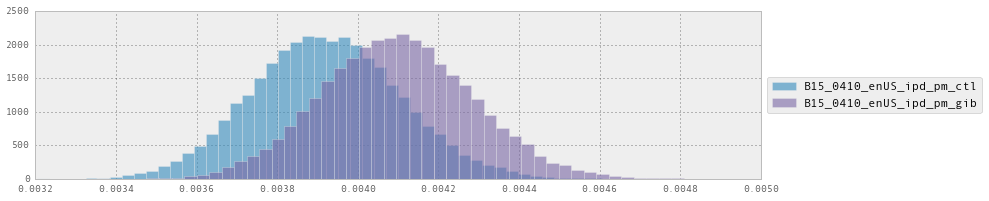

In [27]:
t_ipd_gw.rate_stats(a, b, rate = 'donations/impressions', conf = 95)

### Amount per Impression

Counter({3.0: 215, 15.0: 119, 20.0: 85, 50.0: 12, 10.0: 10, 100.0: 8, 5.0: 5, 6.0: 1})


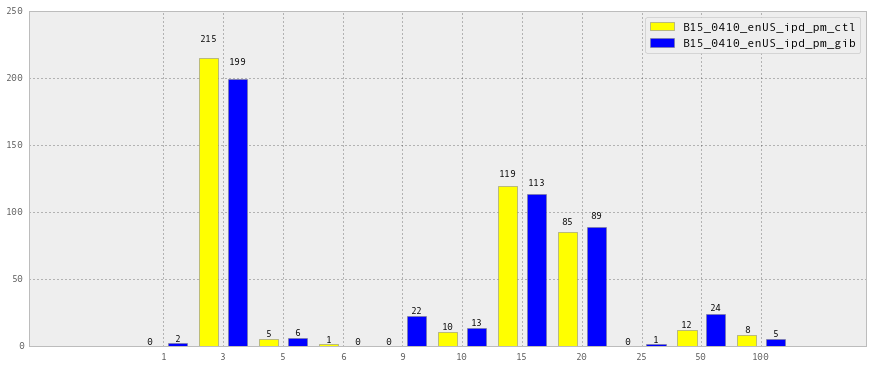

In [28]:
t_ipd_gw.compare_donation_amounts(a, b )

Values for banner  B15_0410_enUS_ipd_pm_gib : [3.0, 15.0, 20.0, 50.0, 9.5999999999999996]
Values for banner  B15_0410_enUS_ipd_pm_ctl : [3.0, 15.0, 20.0, 50.0]


,P(Winner),Winners Lift,CI
B15_0410_enUS_ipd_pm_gib,0.95156,"(0.00%, 0.00%)","(0.042386, 0.054492)"
B15_0410_enUS_ipd_pm_ctl,0.04844,"(-2.74%, 39.14%)","(0.036475, 0.046872)"


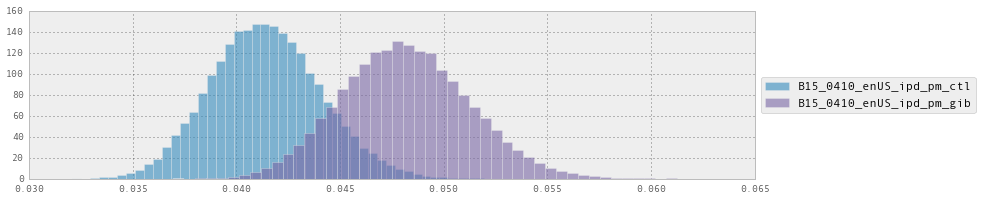

In [49]:
values = {
a: 4,
b: 5
}

t_ipd_gw.amount_stats( values, conf = 95, rate = 'donations/impressions')